In [1]:
import xarray as xr
import geowombat as gw
import os
os.chdir('/home/mmann1123/Documents/github/xr_fresh/')  # change to import xr_fresh
from xr_fresh.feature_calculators import * 
from xr_fresh.backends import Cluster
from xr_fresh.extractors import extract_features
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
from xr_fresh.utils import * 
from xr_fresh import feature_calculators
from itertools import chain
from geowombat.backends import concat as gw_concat
_logger = logging.getLogger(__name__)
from numpy import where
from xr_fresh.utils import xarray_to_rasterio
import pandas as pd
from glob import glob
from pathlib import Path

In [2]:
%%time

pdsi_files = '/home/mmann1123/Dropbox/Ethiopia_data/PDSI'
dates = sorted(datetime.strptime(string, f"{pdsi_files}/pdsi_%Y%m.tif")
        for string in sorted(glob(f"{pdsi_files}/pdsi*tif")))

with gw.open(sorted(glob(f"{pdsi_files}/pdsi*tif")), 
             band_names=['ppt'],
             time_names = dates  ) as ds:
                 
    ds = ds.chunk((len(ds.time), 1, 250, 250)) # time chunk should always = len(ds.time) or {}'time':-1}
    ds.attrs['nodatavals'] =  (-9999,)
print(ds)

<xarray.DataArray (time: 71, band: 1, y: 285, x: 371)>
dask.array<rechunk-merge, shape=(71, 1, 285, 371), dtype=int16, chunksize=(71, 1, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U3 'ppt'
  * y        (y) float64 14.9 14.86 14.82 14.78 ... 3.537 3.497 3.456 3.416
  * x        (x) float64 33.01 33.05 33.09 33.13 ... 47.84 47.88 47.92 47.96
  * time     (time) datetime64[ns] 2013-02-01 2013-03-01 ... 2018-12-01
Attributes:
    transform:      (0.040424187785378464, 0.0, 32.98613723286883, 0.0, -0.04...
    crs:            +init=epsg:4326
    res:            (0.040424187785378464, 0.040424187785378464)
    is_tiled:       0
    nodatavals:     (-9999,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('pdsi',)
    filename:       ['pdsi_201302.tif', 'pdsi_201303.tif', 'pdsi_201304.tif',...
    resampling:     nearest
    AREA_OR_POINT:  Area
CPU times: user 489 ms, sys: 32.3 ms, total: 521 ms
Wall time: 520 ms


<Client: 'inproc://192.168.86.77/136980/1' processes=1 threads=12, memory=67.08 GB>
go to http://localhost:8787/status for dask dashboard
interpolating
IMPORTANT: Persisting pulling all data into memory
Extracting:  maximum
Extracting:  quantile
Extracting:  quantile
CPU times: user 22.1 s, sys: 3.83 s, total: 25.9 s
Wall time: 21.8 s


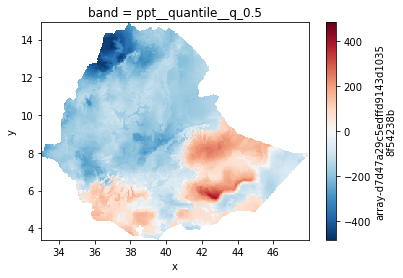

In [3]:
%%time

# start cluster
cluster = Cluster()
cluster.start_large_object()


f_dict = { 'maximum':[{}] ,  
          'quantile': [{'q':"0.5"},{'q':'0.95'}] }
 

# interpolate missing values
print('interpolating')
ds = ds.interpolate_na(dim='time',method='linear', limit=5)

ds = ds.chunk({'time': -1,'band':1,'x':250,'y':250}) # rechunk after interpolation
ds.attrs['nodatavals'] =  (-9999,)


features = extract_features(xr_data=ds,
                            feature_dict=f_dict,
                            band='ppt',
                            dim='variable',
                            na_rm = True,
                            persist=True,   # only if data can fit into memory
                            filepath= None
                           )

out = features.sel(band = "ppt__quantile__q_0.5")
out.plot.imshow()

cluster.close()


In [12]:
%%time
pdsi_files = '/home/mmann1123/Dropbox/Ethiopia_data/PDSI'
dates = sorted(datetime.strptime(string, f"{pdsi_files}/pdsi_%Y%m.tif")
        for string in sorted(glob(f"{pdsi_files}/pdsi*tif")))

with gw.open(sorted(glob(f"{pdsi_files}/pdsi*tif")), 
             band_names=['ppt'],
             time_names = dates  ) as ds:
                 
    ds = ds.chunk((len(ds.time), 1, 250, 250)) # time chunk should always = len(ds.time) or {}'time':-1}
    ds.attrs['nodatavals'] =  (-9999,)

    print(ds)
    
    complete_f =  { 
    #                 'abs_energy':[{}],
    #                 'mean_abs_change':[{}],
    #                 'variance_larger_than_standard_deviation':[{}],
    #                 'ratio_beyond_r_sigma':[{'r':1},{'r':2},{'r':3}],
    #                 'large_standard_deviation':[{'r':0.5},{'r':1},{'r':2},{'r':3}],
    #                 'symmetry_looking':[{}],
    #                 'sum_values':[{}],
    #                 'autocorr':[{'lag':1},{'lag':2}],  
    #                 'ts_complexity_cid_ce':[{}],
    #                 'mean_change':[{}],  # looks weird on ppt series
    #                 'mean_second_derivative_central':[{}], # looks weird on ppt series
                    'median':[{}],
                    'mean':[{}],
    #                 'length':[{}],
    #                 'standard_deviation':[{}],
    #                 'variance':[{}],
    #                 'skewness':[{}],
    #                 'kurtosis':[{}],
    #                 'absolute_sum_of_changes':[{}],
    #                 'longest_strike_below_mean':[{}],
    #                 'longest_strike_above_mean':[{}],
    #                 'count_above_mean':[{}],
    #                 'first_doy_of_maximum':[{'band':'ppt'}],   # figure out how to remove arg for band
    #                 'last_doy_of_maximum':[{'band':'ppt'}],    
    #                 'last_doy_of_minimum':[{'band':'ppt'}],    
    #                 'first_doy_of_minimum':[{'band':'ppt'}],  
    #                 'ratio_value_number_to_time_series_length':[{}],
    #                 'linear_time_trend': [{'param':"pvalue"},{'param':"slope"}], # slow, should run once then get all desired attributes
    #                 'quantile': [{'q':"0.5"},{'q':"0.95"}],
    #                 'maximum':[{}],
    #                 'minimum':[{}] 
                  }



    # start cluster
    cluster = Cluster()
    cluster.start_large_object()


    # interpolate missing values
    print('interpolating')
    ds = ds.interpolate_na(dim='time',method='linear', limit=5)

    ds = ds.chunk({'time': -1,'band':1,'x':250,'y':250}) # time chunk should always = len(ds.time)
    ds.attrs['nodatavals'] =  (-9999,)


    features = extract_features(xr_data=ds,
                                feature_dict=complete_f,
                                band='ppt',
                                filepath = '/home/mmann1123/Downloads/',
                                postfix = '_test',
                                persist=True,
                                na_rm = True)

    # fig, ax = plt.subplots( figsize=(20,20))

    # for i in range(0,5):
    #     img = features[i]
    #     i = i+1
    #     plt.subplot(1,5,i)
    #     plt.imshow(img)

    cluster.close()


<xarray.DataArray (time: 71, band: 1, y: 285, x: 371)>
dask.array<rechunk-merge, shape=(71, 1, 285, 371), dtype=int16, chunksize=(71, 1, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U3 'ppt'
  * y        (y) float64 14.9 14.86 14.82 14.78 ... 3.537 3.497 3.456 3.416
  * x        (x) float64 33.01 33.05 33.09 33.13 ... 47.84 47.88 47.92 47.96
  * time     (time) datetime64[ns] 2013-02-01 2013-03-01 ... 2018-12-01
Attributes:
    transform:      (0.040424187785378464, 0.0, 32.98613723286883, 0.0, -0.04...
    crs:            +init=epsg:4326
    res:            (0.040424187785378464, 0.040424187785378464)
    is_tiled:       0
    nodatavals:     (-9999,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('pdsi',)
    filename:       ['pdsi_201302.tif', 'pdsi_201303.tif', 'pdsi_201304.tif',...
    resampling:     nearest
    AREA_OR_POINT:  Area
<Client: 'inproc://192.168.86.77/136980/37' processes=1 threads=12, memory=67.08 GB>
go to http:

In [11]:
features

<xarray.DataArray 'array-3629072ba5d46fafecefd77bfe93a720' (band: 2, y: 285, x: 371)>
dask.array<array, shape=(2, 285, 371), dtype=float64, chunksize=(1, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U13 'ppt__median__' 'ppt__mean__'
  * y        (y) float64 14.9 14.86 14.82 14.78 ... 3.537 3.497 3.456 3.416
  * x        (x) float64 33.01 33.05 33.09 33.13 ... 47.84 47.88 47.92 47.96
Attributes:
    nodatavals:  (-9999,)

In [9]:
xarray_to_rasterio(features, path='/home/mmann1123/Downloads/', postfix='_test', bands=None)


Error writing
The DataArray does not have a `crs` attribute.
